In [33]:
import pandas as pd

In [34]:
df = pd.read_csv('/Users/luisenriquekaiser/Documents/soccer_betting_forecast/data/processed/merged_data_with_pi_predictions_tuned.csv')


In [37]:
home_odds = ['B365H', 'BWH', 'GBH', 'IWH']
away_odds = ['B365A', 'BWA', 'GBA', 'IWA']
draw_odds = ['B365D', 'BWD', 'GBD', 'IWD']

def get_mean_odds(row, odds_columns):
    """Calculate mean odds, handling missing columns and NaN values"""
    # Filter to only include columns that exist in the dataframe
    valid_cols = [col for col in odds_columns if col in row.index]
    if not valid_cols:
        return float('nan')

    # Get non-NaN values
    values = [row[col] for col in valid_cols if not pd.isna(row[col])]
    return sum(values)/len(values) if values else float('nan')

def compute_probabilities(odds):
    # Check if any odds are NaN
    if any(pd.isna(o) for o in odds):
        return [None, None, None]
    try:
        probabilities = [1 / o for o in odds]
        total = sum(probabilities)
        return [p / total for p in probabilities]
    except (ZeroDivisionError, TypeError):
        return [None, None, None]

# Apply the function to each set of odds
df[['home_prob', 'draw_prob', 'away_prob']] = df.apply(
    lambda row: pd.Series(compute_probabilities([
        get_mean_odds(row, home_odds),
        get_mean_odds(row, draw_odds),
        get_mean_odds(row, away_odds)
    ])), axis=1
)

In [39]:
df

,week,day,date,time,home_team,score,away_team,attendance,venue,referee,...,IWD,IWA,goals_home,goals_away,pred_home_prob,pred_draw_prob,pred_away_prob,home_prob,draw_prob,away_prob
0,1.0,Fri,2017-08-04,20:45,monaco,3–2,toulouse,13572.0,Stade Louis II,Clément Turpin,...,4.7,7.9,3.0,2.0,0.625139,0.221638,0.153222,0.719163,0.178100,0.102738
1,1.0,Sat,2017-08-05,20:00,troyes,1–1,rennes,9968.0,Stade de l'Aube,Karim Abed,...,3.1,2.8,1.0,1.0,0.228893,0.259644,0.511463,0.363258,0.301427,0.335315
2,1.0,Sat,2017-08-05,20:00,saint-étienne,1–0,nice,25879.0,Stade Geoffroy-Guichard,François Letexier,...,3.1,3.1,1.0,0.0,0.216701,0.253298,0.530001,0.419195,0.297849,0.282956
3,1.0,Sat,2017-08-05,17:15,paris s-g,2–0,amiens,46898.0,Parc des Princes,Mikael Lesage,...,6.5,14.0,2.0,0.0,0.794704,0.149587,0.055709,0.837493,0.115049,0.047458
4,1.0,Sat,2017-08-05,20:00,lyon,4–0,strasbourg,1979.0,Groupama Stadium,Ruddy Buquet,...,4.3,7.5,4.0,0.0,0.539676,0.248126,0.212197,0.686683,0.197842,0.115475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14352,38.0,Sun,2025-05-25,20:45,lazio,0–1,lecce,53000.0,Stadio Olimpico,Michael Fabbri,...,NaN,NaN,0.0,1.0,0.638414,0.225234,0.136352,0.618233,0.255648,0.126120
14353,38.0,Sun,2025-05-25,20:45,udinese,2–3,fiorentina,20463.0,Bluenergy Stadium,Matteo Marcenaro,...,NaN,NaN,2.0,3.0,0.303380,0.270462,0.426158,0.257880,0.265043,0.477077
14354,38.0,Sun,2025-05-25,20:45,atalanta,2–3,parma,23161.0,Gewiss Stadium,Livio Marinelli,...,NaN,NaN,2.0,3.0,0.677367,0.204100,0.118532,0.540541,0.270270,0.189189
14355,38.0,Sun,2025-05-25,20:45,venezia,2–3,juventus,12048.0,Stadio Pier Luigi Penzo,Andrea Colombo,...,NaN,NaN,2.0,3.0,0.195116,0.245868,0.559015,0.164308,0.218193,0.617499


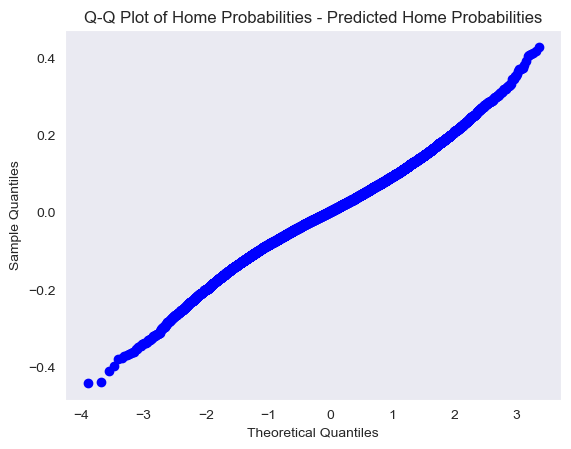

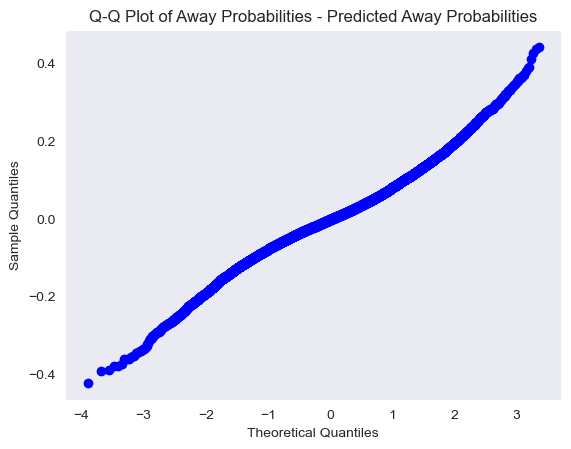

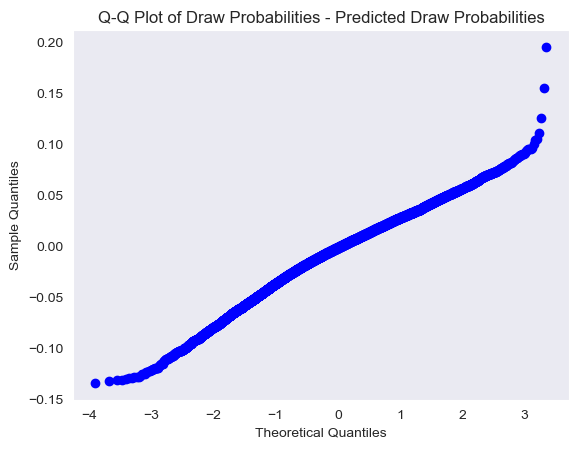

In [38]:
# make q-q plot of the predictions and the bookmaker probs home_prob - pred_home_prob
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
def qq_plot(data, title='Q-Q Plot'):
    stats.probplot(data, dist="norm", plot=plt)
    plt.title(title)
    plt.xlabel('Theoretical Quantiles')
    plt.ylabel('Sample Quantiles')
    plt.grid()
    plt.show()

qq_plot(df['home_prob'] - df['pred_home_prob'], title='Q-Q Plot of Home Probabilities - Predicted Home Probabilities')

# for the away probabilities
qq_plot(df['away_prob'] - df['pred_away_prob'], title='Q-Q Plot of Away Probabilities - Predicted Away Probabilities')

# for the draw probabilities
qq_plot(df['draw_prob'] - df['pred_draw_prob'], title='Q-Q Plot of Draw Probabilities - Predicted Draw Probabilities')

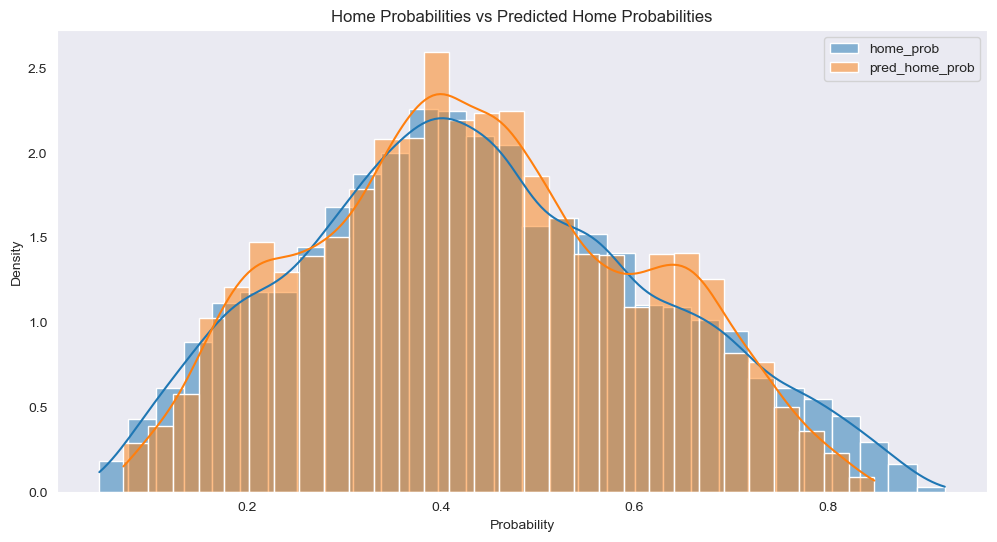

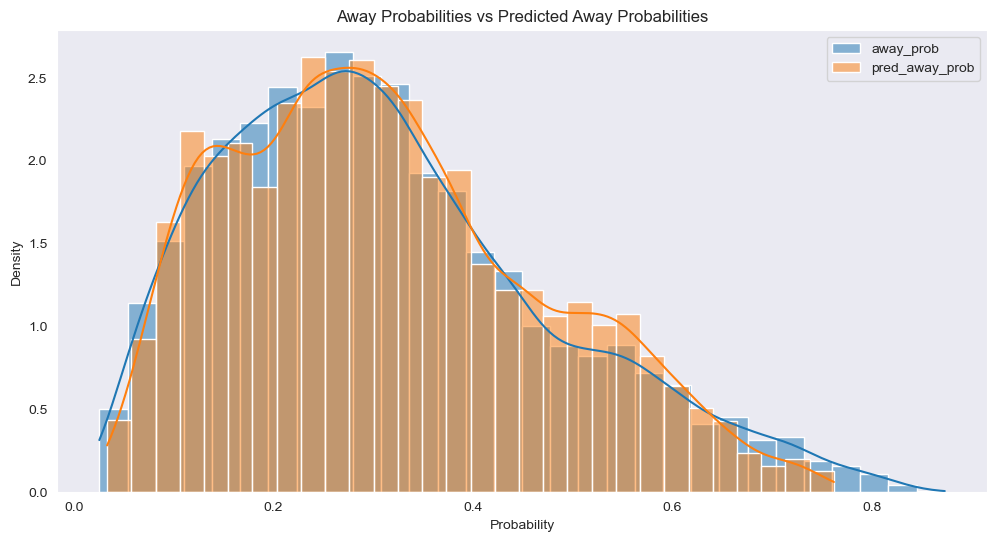

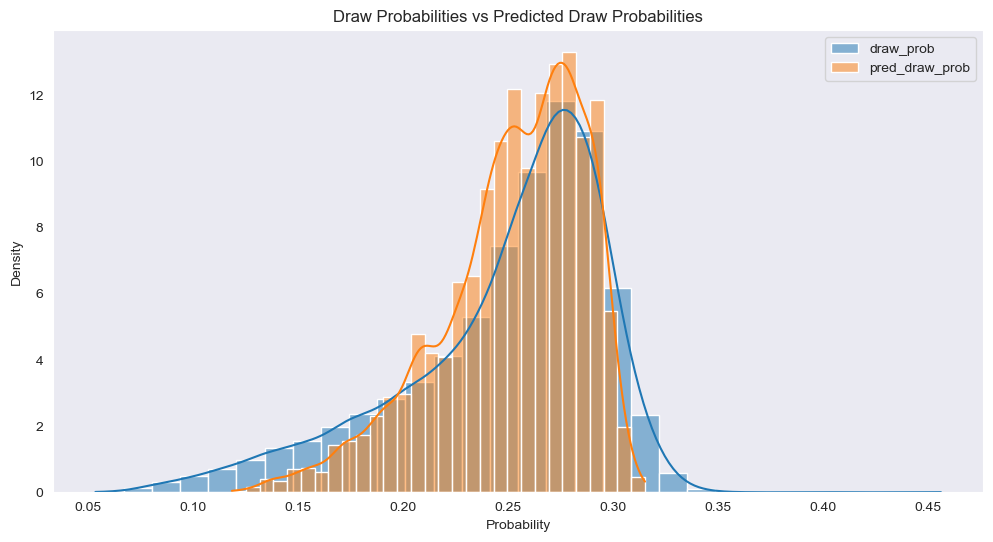

In [40]:
# plot histograms of the home, away and draw probabilities for the predictions and the bookmaker probabilities
def plot_histograms(df, columns, title):
    plt.figure(figsize=(12, 6))
    for column in columns:
        sns.histplot(df[column], kde=True, label=column, stat='density', bins=30)
    plt.title(title)
    plt.xlabel('Probability')
    plt.ylabel('Density')
    plt.legend()
    plt.grid()
    plt.show()

plot_histograms(df, ['home_prob', 'pred_home_prob'], title='Home Probabilities vs Predicted Home Probabilities')
plot_histograms(df, ['away_prob', 'pred_away_prob'], title='Away Probabilities vs Predicted Away Probabilities')
plot_histograms(df, ['draw_prob', 'pred_draw_prob'], title='Draw Probabilities vs Predicted Draw Probabilities')

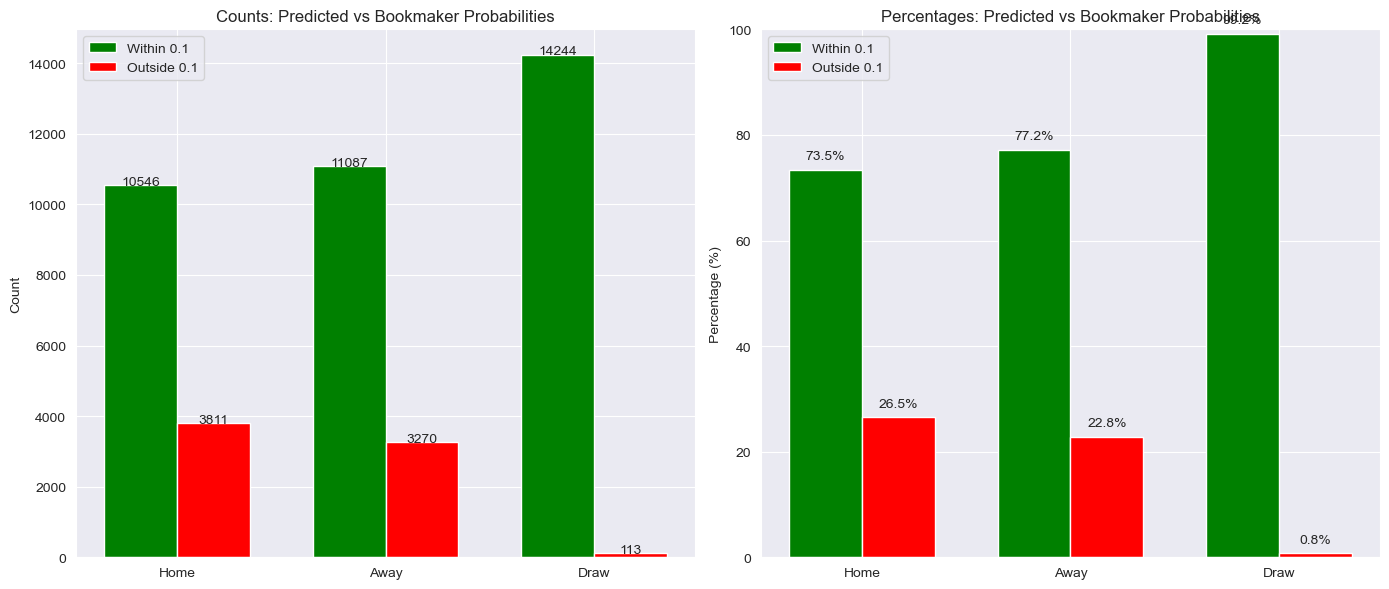

In [44]:
def plot_within_threshold(df, threshold=0.1):
    """
    Plot how often predicted probabilities are within a threshold of bookmaker probabilities.
    Shows both raw counts and percentages.
    """
    # Calculate whether each probability type is within threshold
    within_threshold = {
        'Home': np.abs(df['home_prob'] - df['pred_home_prob']) <= threshold,
        'Away': np.abs(df['away_prob'] - df['pred_away_prob']) <= threshold,
        'Draw': np.abs(df['draw_prob'] - df['pred_draw_prob']) <= threshold
    }

    # Calculate counts and percentages
    results = {}
    for key, values in within_threshold.items():
        total = len(values)
        within_count = values.sum()
        within_pct = within_count / total * 100
        outside_count = total - within_count
        outside_pct = outside_count / total * 100

        results[key] = {
            'Within Count': within_count,
            'Within %': within_pct,
            'Outside Count': outside_count,
            'Outside %': outside_pct
        }

    # Create figure with two subplots - one for counts, one for percentages
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Plot counts
    categories = list(results.keys())
    within_counts = [results[k]['Within Count'] for k in categories]
    outside_counts = [results[k]['Outside Count'] for k in categories]

    x = np.arange(len(categories))
    width = 0.35

    ax1.bar(x - width/2, within_counts, width, label=f'Within {threshold}', color='green')
    ax1.bar(x + width/2, outside_counts, width, label=f'Outside {threshold}', color='red')
    ax1.set_xticks(x)
    ax1.set_xticklabels(categories)
    ax1.set_ylabel('Count')
    ax1.set_title(f'Counts: Predicted vs Bookmaker Probabilities')
    ax1.legend()

    # Add count labels on bars
    for i, v in enumerate(within_counts):
        ax1.text(i - width/2, v + 5, str(v), ha='center')
    for i, v in enumerate(outside_counts):
        ax1.text(i + width/2, v + 5, str(v), ha='center')

    # Plot percentages
    within_pcts = [results[k]['Within %'] for k in categories]
    outside_pcts = [results[k]['Outside %'] for k in categories]

    ax2.bar(x - width/2, within_pcts, width, label=f'Within {threshold}', color='green')
    ax2.bar(x + width/2, outside_pcts, width, label=f'Outside {threshold}', color='red')
    ax2.set_xticks(x)
    ax2.set_xticklabels(categories)
    ax2.set_ylabel('Percentage (%)')
    ax2.set_title(f'Percentages: Predicted vs Bookmaker Probabilities')
    ax2.set_ylim(0, 100)
    ax2.legend()

    # Add percentage labels on bars
    for i, v in enumerate(within_pcts):
        ax2.text(i - width/2, v + 2, f'{v:.1f}%', ha='center')
    for i, v in enumerate(outside_pcts):
        ax2.text(i + width/2, v + 2, f'{v:.1f}%', ha='center')

    plt.tight_layout()
    plt.show()

# Test the function
plot_within_threshold(df, threshold=0.1)

In [47]:
# share of predictions, which are lower than the bookmakers probabilities by 5 percent

def share_lower_than_bookmaker(df, threshold=0.05):
    """
    Calculate the share of predictions that are lower than the bookmaker probabilities by a given threshold.
    """
    results = {
        'Home': (df['pred_home_prob'] < df['home_prob'] - threshold).mean() * 100,
        'Away': (df['pred_away_prob'] < df['away_prob'] - threshold).mean() * 100,
        'Draw': (df['pred_draw_prob'] < df['draw_prob'] - threshold).mean() * 100
    }

    return results

# Test the function
share_results = share_lower_than_bookmaker(df, threshold=0.05)
print("Share of Predictions Lower than Bookmaker Probabilities by 5%:")
for key, value in share_results.items():
    print(f"{key}: {value:.2f}%")

Share of Predictions Lower than Bookmaker Probabilities by 5%:
Home: 29.41%
Away: 24.55%
Draw: 3.85%


In [48]:
# share of higher than bookmaker probabilities by 5 percent
def share_higher_than_bookmaker(df, threshold=0.9):
    """
    Calculate the share of predictions that are higher than the bookmaker probabilities by a given threshold.
    """
    results = {
        'Home': (df['pred_home_prob'] > df['home_prob'] + threshold).mean() * 100,
        'Away': (df['pred_away_prob'] > df['away_prob'] + threshold).mean() * 100,
        'Draw': (df['pred_draw_prob'] > df['draw_prob'] + threshold).mean() * 100
    }

    return results
# Test the function
# Python
share_results_higher = share_higher_than_bookmaker(df, threshold=0.10)
print("Share of Predictions Higher than Bookmaker Probabilities by 90%:")
for key, value in share_results_higher.items():
    print(f"{key}: {value:.2f}%")

Share of Predictions Higher than Bookmaker Probabilities by 90%:
Home: 12.15%
Away: 11.03%
Draw: 0.70%


In [49]:
# Python
# Assign match outcome: 1 = home win, 0 = draw, -1 = away win
df["outcome"] = 0
df.loc[df['goals_home'] > df['goals_away'], 'outcome'] = 1
df.loc[df['goals_home'] < df['goals_away'], 'outcome'] = -1
df.loc[df['goals_home'] == df['goals_away'], 'outcome'] = 0


# get the prediction based on the highest predicted probability
def get_prediction(row):
    if row['pred_home_prob'] > row['pred_away_prob'] and row['pred_home_prob'] > row['pred_draw_prob']:
        return 1  # Home win
    elif row['pred_away_prob'] > row['pred_home_prob'] and row['pred_away_prob'] > row['pred_draw_prob']:
        return -1  # Away win
    else:
        return 0  # Draw

def get_prediction_bookies(row):
    if row['home_prob'] > row['away_prob'] and row['home_prob'] > row['draw_prob']:
        return 1  # Home win
    elif row['away_prob'] > row['home_prob'] and row['away_prob'] > row['pred_draw_prob']:
        return -1  # Away win
    else:
        return 0  # Draw

# Apply the function to get predictions
df['predicted_outcome_model'] = df.apply(get_prediction, axis=1)
df['predicted_outcome_bookies'] = df.apply(get_prediction_bookies, axis=1)

# Calculate accuracy
def calculate_accuracy(df, model_col, bookies_col):
    """
    Calculate the accuracy of predictions compared to actual outcomes.
    Returns the accuracy as a percentage.

    """
    correct_model = (df[model_col] == df['outcome']).sum()
    total_model = len(df)
    accuracy_model = correct_model / total_model * 100


    correct_bookies = (df[bookies_col] == df['outcome']).sum()
    total_bookies = len(df)
    accuracy_bookies = correct_bookies / total_bookies * 100

    return accuracy_model, accuracy_bookies

# Calculate accuracy for model and bookies
accuracy_model, accuracy_bookies = calculate_accuracy(df, 'predicted_outcome_model', 'predicted_outcome_bookies')
print(f"Model Accuracy: {accuracy_model:.2f}%")
print(f"Bookies Accuracy: {accuracy_bookies:.2f}%")


Model Accuracy: 52.51%
Bookies Accuracy: 53.77%


In [50]:
df

,week,day,date,time,home_team,score,away_team,attendance,venue,referee,...,goals_away,pred_home_prob,pred_draw_prob,pred_away_prob,home_prob,draw_prob,away_prob,outcome,predicted_outcome_model,predicted_outcome_bookies
0,1.0,Fri,2017-08-04,20:45,monaco,3–2,toulouse,13572.0,Stade Louis II,Clément Turpin,...,2.0,0.625139,0.221638,0.153222,0.719163,0.178100,0.102738,1,1,1
1,1.0,Sat,2017-08-05,20:00,troyes,1–1,rennes,9968.0,Stade de l'Aube,Karim Abed,...,1.0,0.228893,0.259644,0.511463,0.363258,0.301427,0.335315,0,-1,1
2,1.0,Sat,2017-08-05,20:00,saint-étienne,1–0,nice,25879.0,Stade Geoffroy-Guichard,François Letexier,...,0.0,0.216701,0.253298,0.530001,0.419195,0.297849,0.282956,1,-1,1
3,1.0,Sat,2017-08-05,17:15,paris s-g,2–0,amiens,46898.0,Parc des Princes,Mikael Lesage,...,0.0,0.794704,0.149587,0.055709,0.837493,0.115049,0.047458,1,1,1
4,1.0,Sat,2017-08-05,20:00,lyon,4–0,strasbourg,1979.0,Groupama Stadium,Ruddy Buquet,...,0.0,0.539676,0.248126,0.212197,0.686683,0.197842,0.115475,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14352,38.0,Sun,2025-05-25,20:45,lazio,0–1,lecce,53000.0,Stadio Olimpico,Michael Fabbri,...,1.0,0.638414,0.225234,0.136352,0.618233,0.255648,0.126120,-1,1,1
14353,38.0,Sun,2025-05-25,20:45,udinese,2–3,fiorentina,20463.0,Bluenergy Stadium,Matteo Marcenaro,...,3.0,0.303380,0.270462,0.426158,0.257880,0.265043,0.477077,-1,-1,-1
14354,38.0,Sun,2025-05-25,20:45,atalanta,2–3,parma,23161.0,Gewiss Stadium,Livio Marinelli,...,3.0,0.677367,0.204100,0.118532,0.540541,0.270270,0.189189,-1,1,1
14355,38.0,Sun,2025-05-25,20:45,venezia,2–3,juventus,12048.0,Stadio Pier Luigi Penzo,Andrea Colombo,...,3.0,0.195116,0.245868,0.559015,0.164308,0.218193,0.617499,-1,-1,-1


In [64]:
# first 5 gamedays
first_10 = df[df["week"] <= 1]

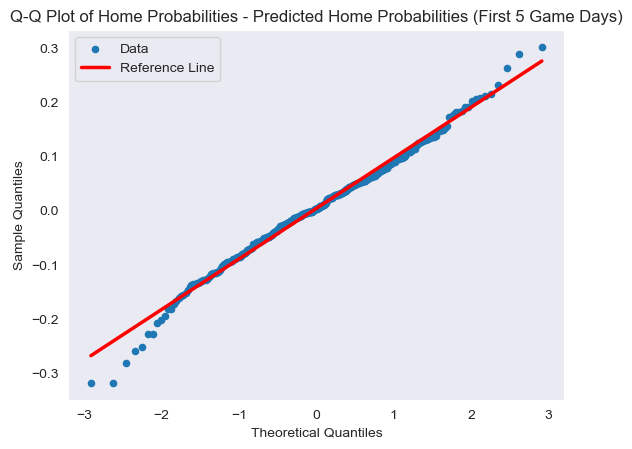

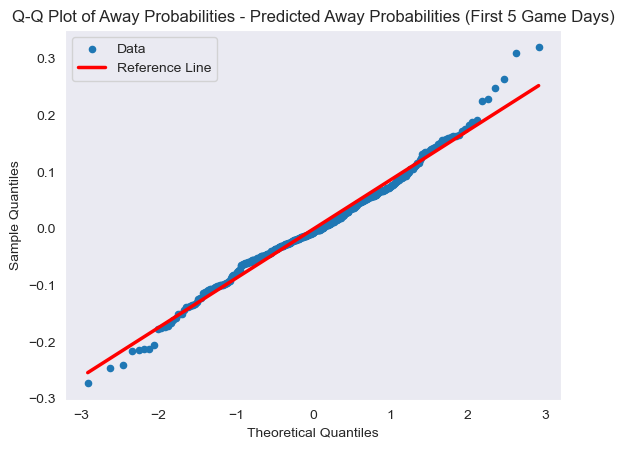

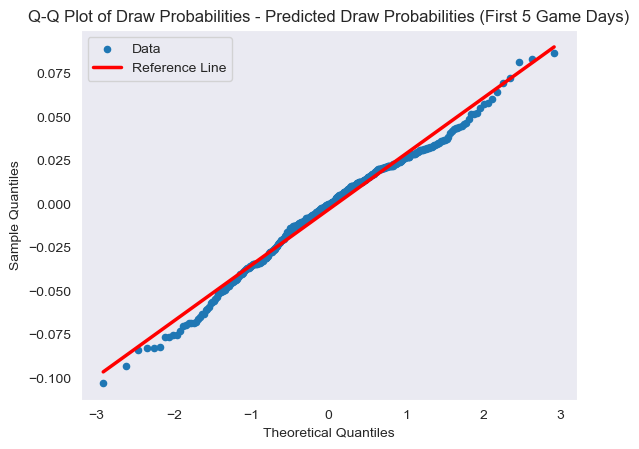

In [65]:
# Python
def qq_plot(data, title='Q-Q Plot'):
    (osm, osr), (slope, intercept, r) = stats.probplot(data, dist="norm")
    plt.figure()
    plt.scatter(osm, osr, s=20, label='Data')
    # Draw the reference line with custom style
    plt.plot(osm, slope * osm + intercept, color='red', linewidth=2.5, label='Reference Line')
    plt.title(title)
    plt.xlabel('Theoretical Quantiles')
    plt.ylabel('Sample Quantiles')
    plt.legend()
    plt.grid()
    plt.show()
# get the qq plot for the first 5
qq_plot(first_10['home_prob'] - first_10['pred_home_prob'], title='Q-Q Plot of Home Probabilities - Predicted Home Probabilities (First 5 Game Days)')

# for the away probabilities
qq_plot(first_10['away_prob'] - first_10['pred_away_prob'], title='Q-Q Plot of Away Probabilities - Predicted Away Probabilities (First 5 Game Days)')
# for the draw probabilities
qq_plot(first_10['draw_prob'] - first_10['pred_draw_prob'], title='Q-Q Plot of Draw Probabilities - Predicted Draw Probabilities (First 5 Game Days)')

In [63]:
# accurarcy for the first 5 game days
accuracy_model_first_5, accuracy_bookies_first_5 = calculate_accuracy(first_10, 'predicted_outcome_model', 'predicted_outcome_bookies')
print(f"Model Accuracy (First 5 Game Days): {accuracy_model_first_5:.2f}%")
print(f"Bookies Accuracy (First 5 Game Days): {accuracy_bookies_first_5:.2f}%")

Model Accuracy (First 5 Game Days): 53.31%
Bookies Accuracy (First 5 Game Days): 54.03%
